In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from image_processing import *

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.16.1
Keras version:  3.1.1
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset_grayscale')
models_dir = os.path.join(local_dir, 'models_grayscale')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']
splits = ['train', 'val', 'test']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir, split_proportions=[0.7, 0.15, 0.15])
    convert_images_to_grayscale(dataset_dir, splits, classes)
    

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

./dataset_grayscale\train
    - rock: 1322 images
    - paper: 1336 images
    - scissors: 1350 images
./dataset_grayscale\val
    - rock: 283 images
    - paper: 286 images
    - scissors: 290 images
./dataset_grayscale\test
    - rock: 284 images
    - paper: 287 images
    - scissors: 290 images


In [3]:
check_for_duplicates_in_dataset('./dataset_grayscale')

No duplicates found in dataset
5728 files found in dataset


Found 4008 images belonging to 3 classes.
Found 859 images belonging to 3 classes.
Found 861 images belonging to 3 classes.


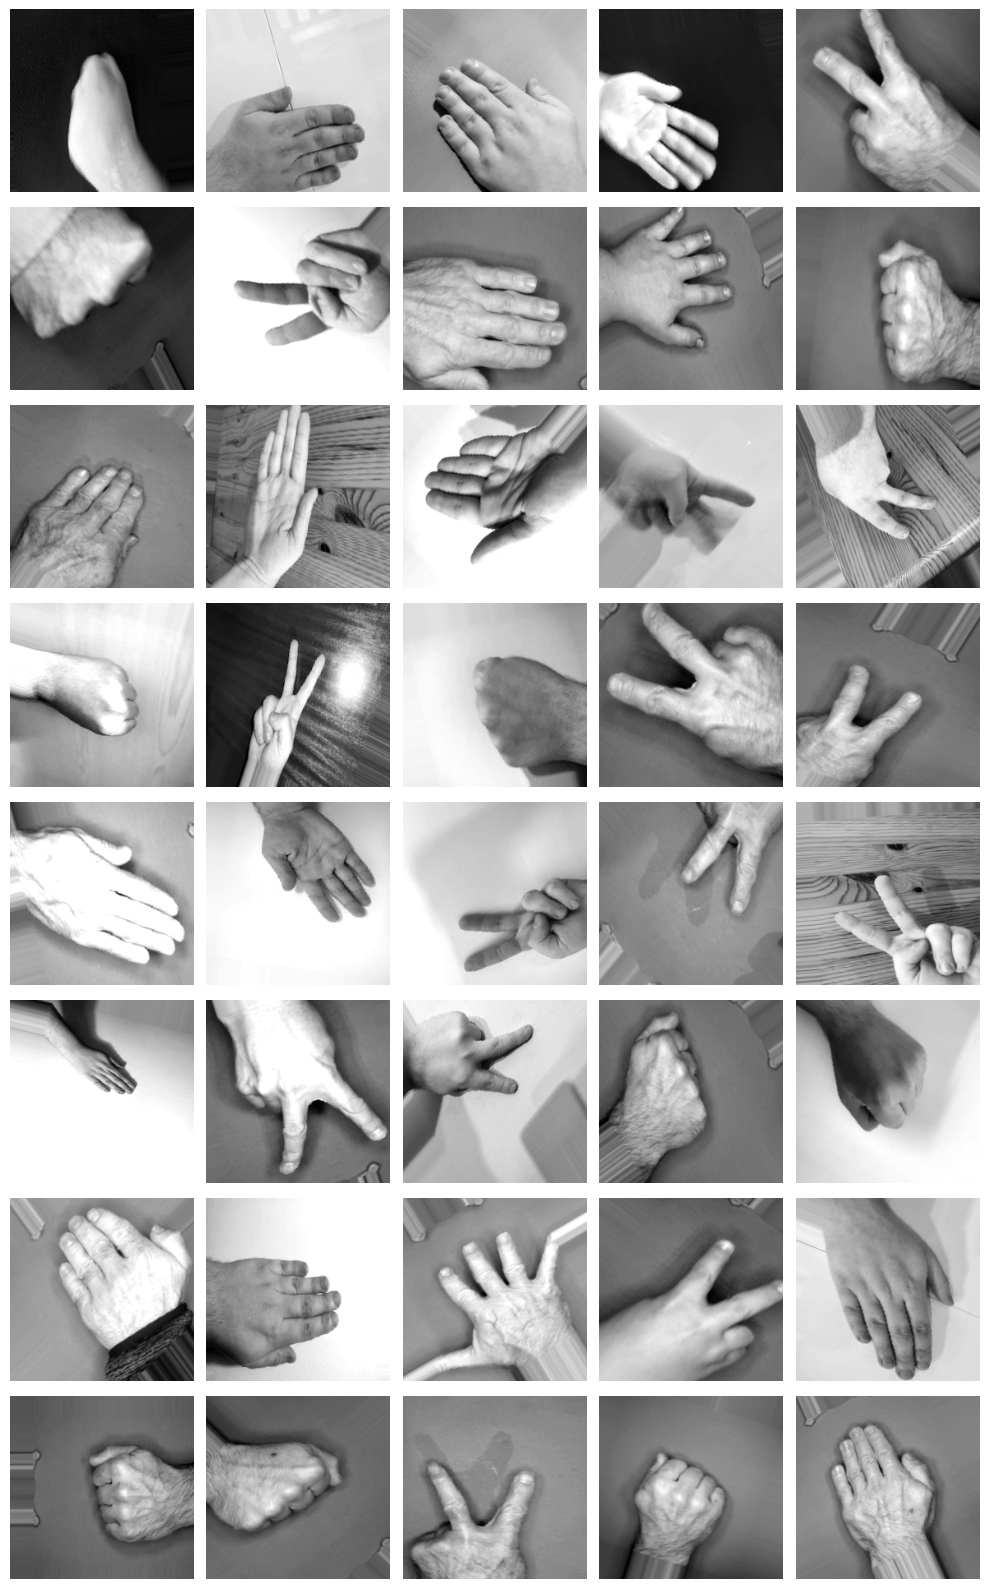

In [4]:
# Image target size
img_rows, img_cols = 224, 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    brightness_range=[0.7, 1.4],
    preprocessing_function=lambda image: random_contrast_grayscale(image, 0.8, 1.2)
    )


test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

plot_grid_from_generator(train_generator, 8, 5, cmap='gray')

In [5]:
EPOCHS = 100
MODEL_NAME = 'cnn_medium_100_epochs'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

# Channels: 1 for grayscale (3 for RGB), arg 'input_shape' in the model
hist_dict = compile_and_train_model(
    create_model_func=build_cnn_medium,
    create_model_args={'input_shape' : (224, 224, 1), 'num_classes' :3},
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback]
)


c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 120s 897ms/step - acc: 0.4811 - loss: 1.2731 - val_acc: 0.3295 - val_loss: 2.7237
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - acc: 0.6336 - loss: 0.8761 - val_acc: 0.3295 - val_loss: 3.4535
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - acc: 0.6850 - loss: 0.7621 - val_acc: 0.3295 - val_loss: 2.8716
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - acc: 0.7207 - loss: 0.6880 - val_acc: 0.4808 - val_loss: 1.2137
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - acc: 0.7589 - loss: 0.6203 - val_acc: 0.7905 - val_loss: 0.5597
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.7779 - loss: 0.5739 - val_acc: 0.7066 - val_loss: 0.7153
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - acc: 0.7899 - loss: 0.5541 - val_acc: 0.8813 - val_loss: 0.3725
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 98s 769ms/step - acc: 0.8066 - loss: 0.5192 - val_acc: 0.8568 - val_loss: 0.4433
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 100s 7

Model saved in ./models_grayscale\cnn_medium_100_epochs.h5
History saved in ./models_grayscale\cnn_medium_100_epochs_history.pkl


<Figure size 640x480 with 0 Axes>

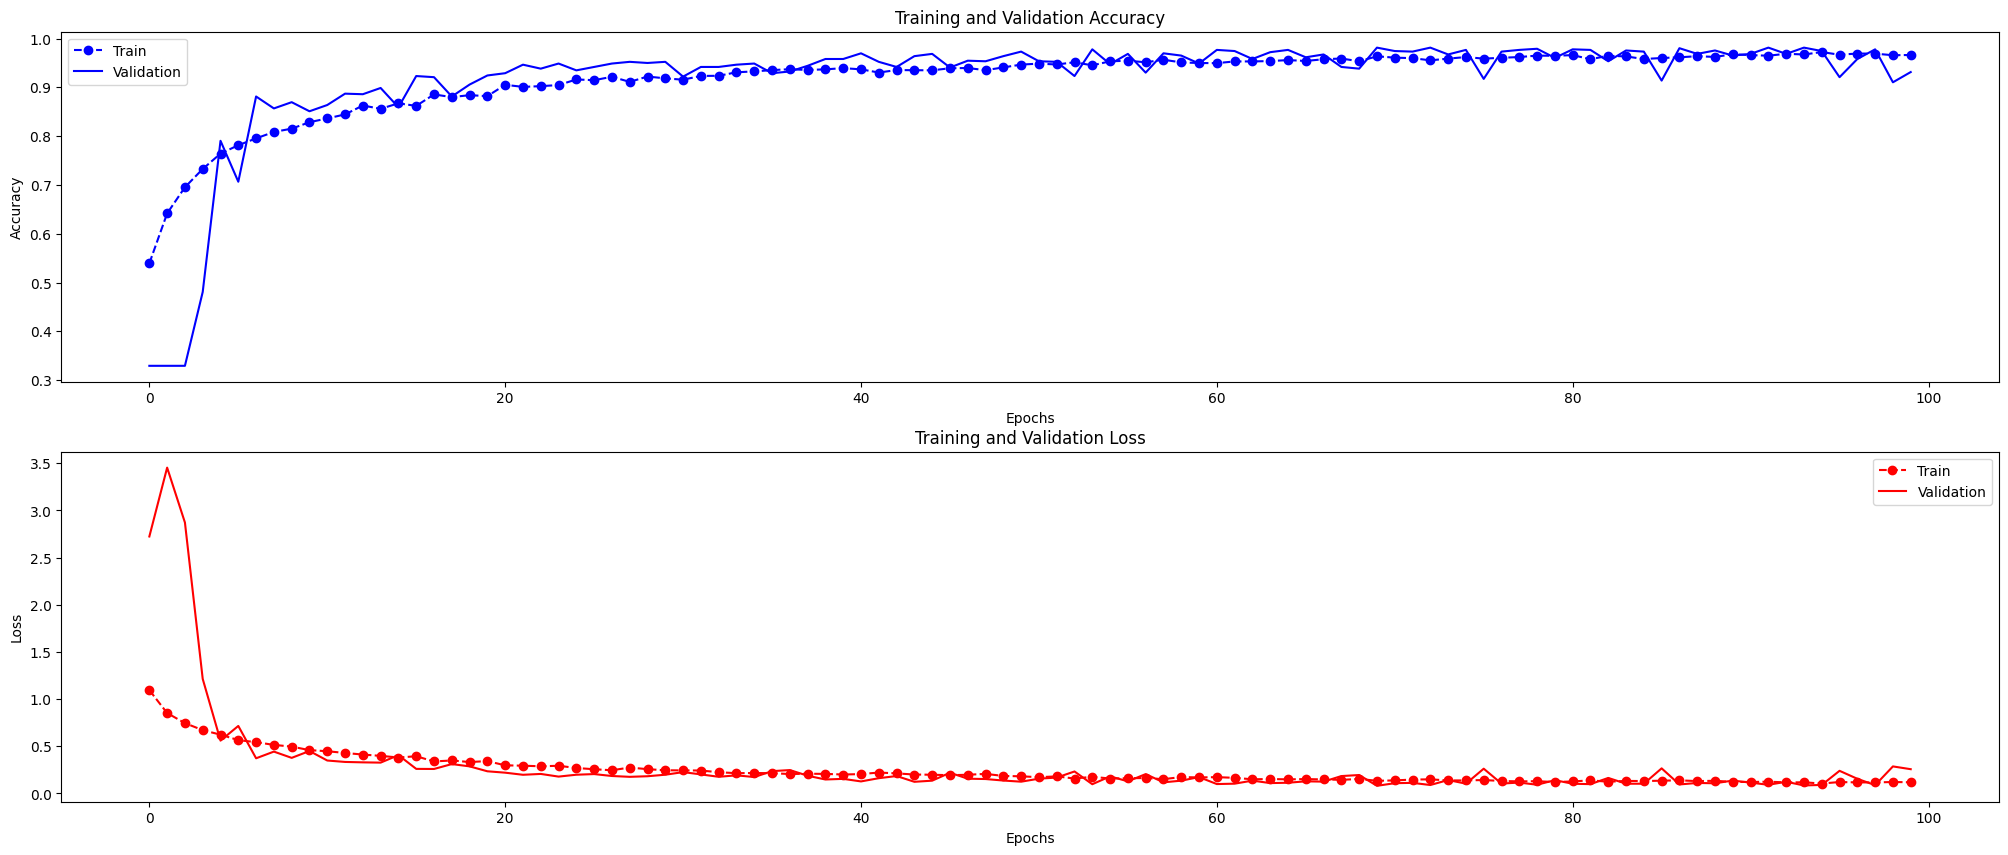

In [6]:
plot_accuracy_and_loss(hist_dict)